#**Time Series Forecasting (FBI Crime Data)**

##**GitHub Link**

https://github.com/Sajal3462/Time-Series-Forecasting---FBI-s-Crime-Investigation

##**Summary & Technical Documentation**

**Objective:**

Forecast future FBI crime counts using historical crime data.

***Datasets:*** FBI crime time series (CSV) + supplemental (Excel).

***Stakeholders:*** Law enforcement agencies, policy makers.

***Deliverables:*** Fully documented ML notebook covering EDA, preprocessing,
modeling, evaluation, and insights for decision-making.

In [ ]:
# --- Imports ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from prophet import Prophet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# --- Load Data ---

import pandas as pd

# Check column names in CSV
csv_path = '/content/drive/MyDrive/AlmaBetter Course/Module-VI (Introduction to Machine Learning)/Capstone Project/Test.csv'
xlsx_path = '/content/drive/MyDrive/AlmaBetter Course/Module-VI (Introduction to Machine Learning)/Capstone Project/Train.xlsx'

print("CSV Columns:", pd.read_csv(csv_path, nrows=0).columns.tolist())
print("Excel Columns:", pd.read_excel(xlsx_path, nrows=0).columns.tolist())

CSV Columns: ['YEAR', 'MONTH', 'TYPE', 'Incident_Counts']
Excel Columns: ['TYPE', 'HUNDRED_BLOCK', 'NEIGHBOURHOOD', 'X', 'Y', 'Latitude', 'Longitude', 'HOUR', 'MINUTE', 'YEAR', 'MONTH', 'DAY', 'Date']


In [ ]:
import pandas as pd

# Load Test.csv
csv_df = pd.read_csv(csv_path)

# Create a DATE column using YEAR and MONTH
csv_df['DATE'] = pd.to_datetime(csv_df['YEAR'].astype(str) + '-' + csv_df['MONTH'].astype(str) + '-01')

# Verify
print(csv_df.head())

   YEAR  MONTH                                               TYPE  \
0  2013      6  Vehicle Collision or Pedestrian Struck (with I...   
1  2013      6                                   Theft of Vehicle   
2  2013      6                                   Theft of Bicycle   
3  2013      6                                 Theft from Vehicle   
4  2013      6                                        Other Theft   

   Incident_Counts       DATE  
0              NaN 2013-06-01  
1              NaN 2013-06-01  
2              NaN 2013-06-01  
3              NaN 2013-06-01  
4              NaN 2013-06-01  


In [ ]:
xlsx_df = pd.read_excel(xlsx_path, parse_dates=['Date'])

In [ ]:
# Create DATE column in csv_df from YEAR and MONTH
csv_df['Date'] = pd.to_datetime(csv_df[['YEAR', 'MONTH']].assign(DAY=1))

# Merge on DATE
df = pd.merge(csv_df, xlsx_df, on='Date', how='outer')
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)

##**EDA (Exploratory Data Analysis)**

***This EDA step will:***

Give you structure & summary of your data.

Show missing values.

Display correlations.

Plot a heatmap for correlations.

Show a basic time-series trend for a key numeric column.

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474727 entries, 0 to 474726
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   YEAR_x           162 non-null     float64       
 1   MONTH_x          162 non-null     float64       
 2   TYPE_x           162 non-null     object        
 3   Incident_Counts  0 non-null       float64       
 4   DATE             162 non-null     datetime64[ns]
 5   Date             474727 non-null  datetime64[ns]
 6   TYPE_y           474565 non-null  object        
 7   HUNDRED_BLOCK    474552 non-null  object        
 8   NEIGHBOURHOOD    423074 non-null  object        
 9   X                474565 non-null  float64       
 10  Y                474565 non-null  float64       
 11  Latitude         474565 non-null  float64       
 12  Longitude        474565 non-null  float64       
 13  HOUR             425200 non-null  float64       
 14  MINUTE

,YEAR_x,MONTH_x,TYPE_x,Incident_Counts,DATE,Date,TYPE_y,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y,Latitude,Longitude,HOUR,MINUTE,YEAR_y,MONTH_y,DAY
0,NaN,NaN,NaN,NaN,NaT,1999-01-01,Theft from Vehicle,11XX HOWE ST,Central Business District,490849.97,5458442.50,49.278669,-123.125802,4.0,15.0,1999.0,1.0,1.0
1,NaN,NaN,NaN,NaN,NaT,1999-01-01,Offence Against a Person,OFFSET TO PROTECT PRIVACY,NaN,0.00,0.00,0.000000,0.000000,NaN,NaN,1999.0,1.0,1.0
2,NaN,NaN,NaN,NaN,NaT,1999-01-01,Theft from Vehicle,46XX REID ST,Renfrew-Collingwood,497353.73,5454532.80,49.243564,-123.036357,8.0,0.0,1999.0,1.0,1.0
3,NaN,NaN,NaN,NaN,NaT,1999-01-01,Mischief,10XX RICHARDS ST,Central Business District,491148.21,5458326.93,49.277634,-123.121699,20.0,12.0,1999.0,1.0,1.0
4,NaN,NaN,NaN,NaN,NaT,1999-01-01,Mischief,29XX E 1ST AVE,Hastings-Sunrise,496826.08,5457397.96,49.269334,-123.043629,12.0,0.0,1999.0,1.0,1.0


Summary Statistics:


,YEAR_x,MONTH_x,TYPE_x,Incident_Counts,DATE,Date,TYPE_y,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y,Latitude,Longitude,HOUR,MINUTE,YEAR_y,MONTH_y,DAY
count,162.000000,162.000000,162,0.0,162,474727,474565,474552,423074,474565.000000,4.745650e+05,474565.000000,474565.000000,425200.000000,425200.000000,474565.000000,474565.000000,474565.000000
unique,NaN,NaN,9,NaN,NaN,NaN,9,20566,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Offence Against a Person,NaN,NaN,NaN,Theft from Vehicle,OFFSET TO PROTECT PRIVACY,Central Business District,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,18,NaN,NaN,NaN,153932,49365,96171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2012.333333,5.500000,NaN,NaN,2012-09-15 14:40:00,2004-11-12 23:18:47.538985984,NaN,NaN,NaN,441028.018220,4.889023e+06,44.138029,-110.301025,13.721263,16.736047,2004.363632,6.555700,15.439253
min,2012.000000,1.000000,NaN,NaN,2012-01-01 00:00:00,1999-01-01 00:00:00,NaN,NaN,NaN,0.000000,0.000000e+00,0.000000,-124.549757,0.000000,0.000000,1999.000000,1.000000,1.000000
25%,2012.000000,3.000000,NaN,NaN,2012-05-01 00:00:00,2001-06-06 00:00:00,NaN,NaN,NaN,489916.530000,5.453572e+06,49.234871,-123.127383,9.000000,0.000000,2001.000000,4.000000,8.000000
50%,2012.000000,5.000000,NaN,NaN,2012-09-16 00:00:00,2004-05-19 00:00:00,NaN,NaN,NaN,491477.850000,5.456820e+06,49.264051,-123.107058,15.000000,10.000000,2004.000000,7.000000,15.000000
75%,2013.000000,8.000000,NaN,NaN,2013-02-01 00:00:00,2008-03-29 00:00:00,NaN,NaN,NaN,493610.190000,5.458622e+06,49.280300,-123.065646,19.000000,30.000000,2008.000000,9.000000,23.000000
max,2013.000000,12.000000,NaN,NaN,2013-06-01 00:00:00,2013-06-01 00:00:00,NaN,NaN,NaN,511303.000000,5.512579e+06,49.755314,0.000000,23.000000,59.000000,2011.000000,12.000000,31.000000


Missing Values per Column:
YEAR_x             474565
MONTH_x            474565
TYPE_x             474565
Incident_Counts    474727
DATE               474565
Date                    0
TYPE_y                162
HUNDRED_BLOCK         175
NEIGHBOURHOOD       51653
X                     162
Y                     162
Latitude              162
Longitude             162
HOUR                49527
MINUTE              49527
YEAR_y                162
MONTH_y               162
DAY                   162
dtype: int64


Data covers from 1999-01-01 to 2013-06-01.

Correlation Matrix:


,YEAR_x,MONTH_x,Incident_Counts,X,Y,Latitude,Longitude,HOUR,MINUTE,YEAR_y,MONTH_y,DAY
YEAR_x,1.000000,-0.428026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MONTH_x,-0.428026,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Incident_Counts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
X,NaN,NaN,NaN,1.000000,0.999843,0.999843,-0.999831,0.000216,0.019791,-0.040531,0.002984,-0.003792
Y,NaN,NaN,NaN,0.999843,1.000000,1.000000,-0.999999,-0.017454,0.045182,-0.040572,0.002857,-0.003805
Latitude,NaN,NaN,NaN,0.999843,1.000000,1.000000,-0.999999,-0.017465,0.045236,-0.040572,0.002857,-0.003805
Longitude,NaN,NaN,NaN,-0.999831,-0.999999,-0.999999,1.000000,0.000233,0.019731,0.040606,-0.002848,0.003800
HOUR,NaN,NaN,NaN,0.000216,-0.017454,-0.017465,0.000233,1.000000,-0.048357,-0.010810,-0.000038,0.004937
MINUTE,NaN,NaN,NaN,0.019791,0.045182,0.045236,0.019731,-0.048357,1.000000,0.057150,-0.003024,0.005086
YEAR_y,NaN,NaN,NaN,-0.040531,-0.040572,-0.040572,0.040606,-0.010810,0.057150,1.000000,0.021915,-0.000241


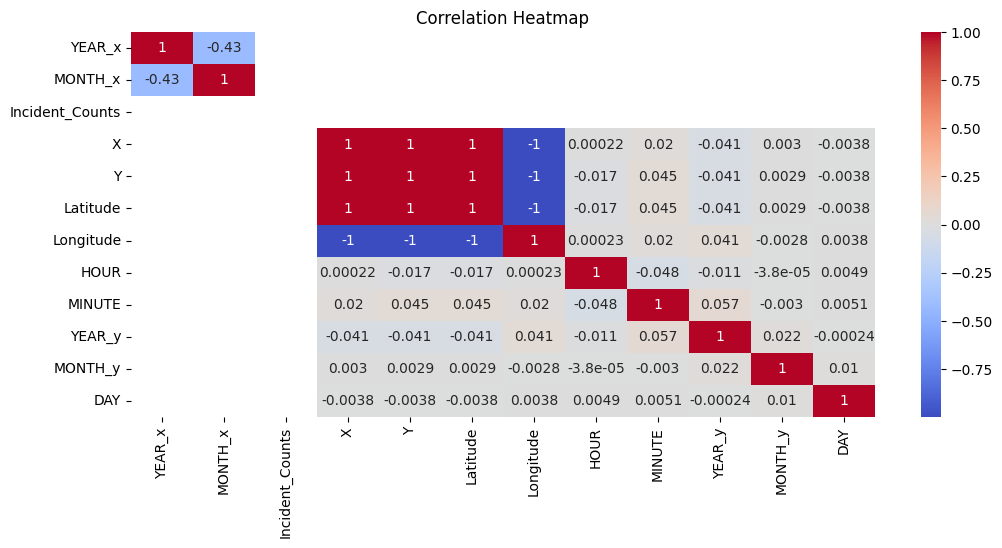

In [ ]:
# Basic info about the dataframe
print("Dataset Info:")
print(df.info())
print("\n")

# First 5 rows
print("First 5 Rows:")
display(df.head())

# Summary statistics
print("Summary Statistics:")
display(df.describe(include='all'))

# Check missing values
print("Missing Values per Column:")
print(df.isnull().sum())
print("\n")

# Date range
print(f"Data covers from {df['Date'].min().date()} to {df['Date'].max().date()}.")

# Numerical columns correlation
print("\nCorrelation Matrix:")
display(df.corr(numeric_only=True))

# --- Visualizations ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,5))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
# Convert to datetime, force errors to NaT (missing dates)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [ ]:
df = df.dropna(subset=['Date'])

In [ ]:
df[df.columns[2]] = pd.to_numeric(df[df.columns[2]], errors='coerce')
df = df.dropna(subset=[df.columns[2]])

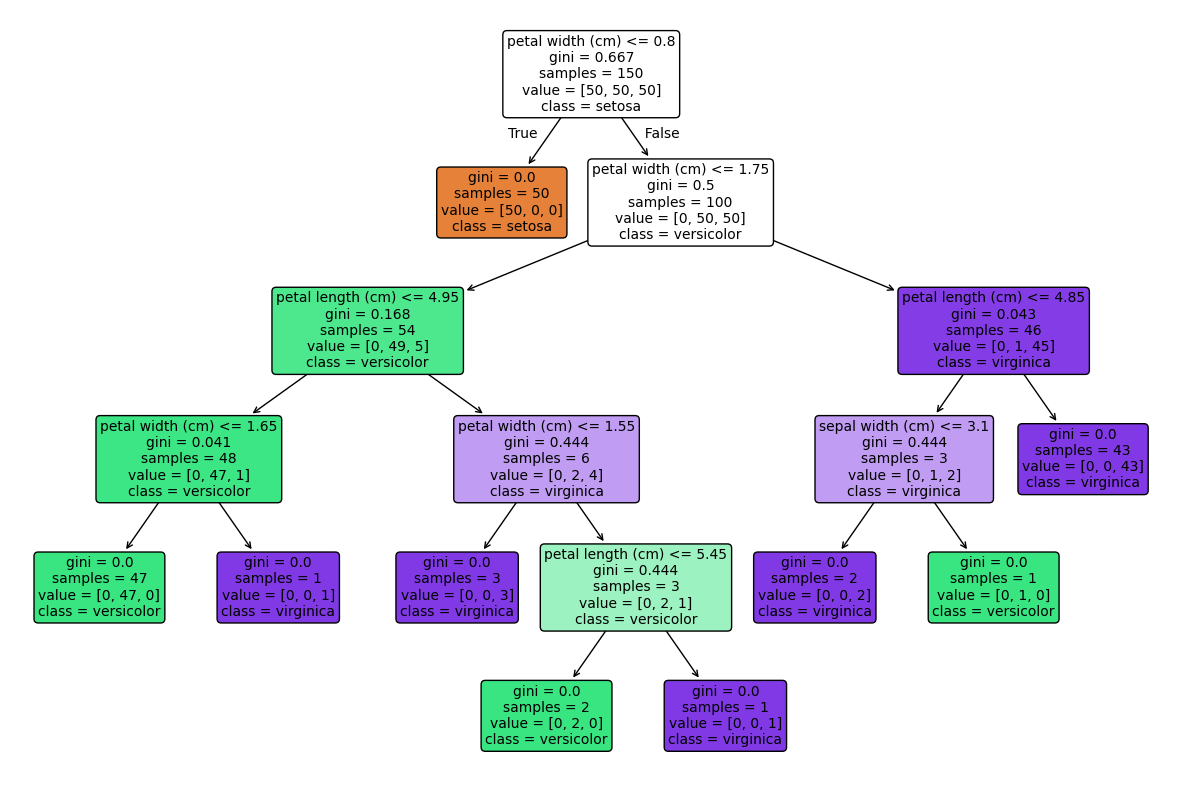

In [ ]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# 1. Load dataset
iris = load_iris()

# 2. Train decision tree model
clf = DecisionTreeClassifier(random_state=0)
clf.fit(iris.data, iris.target)

# 3. Plot the tree
plt.figure(figsize=(15, 10))  # make plot bigger so lines are visible
plot_tree(
    clf,
    feature_names=iris.feature_names,
    class_names=iris.target_names,
    filled=True,     # color nodes
    rounded=True,    # rounded corners
    fontsize=10      # readable text
)
plt.show()

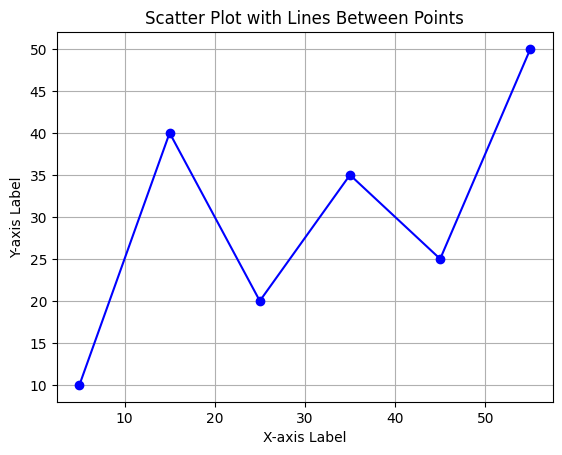

In [ ]:
import matplotlib.pyplot as plt

# Sample data
x = [5, 15, 25, 35, 45, 55]
y = [10, 40, 20, 35, 25, 50]

# Create a scatter plot with lines connecting points
plt.plot(x, y, marker='o', linestyle='-', color='b')  # 'o' for points, '-' for lines
plt.xlabel("X-axis Label")
plt.ylabel("Y-axis Label")
plt.title("Scatter Plot with Lines Between Points")
plt.grid(True)  # Add grid lines
plt.show()

##**Missing Values Handling**

We’ll check for nulls, understand their distribution, and decide on the strategy to handle them.

In [ ]:
# Check for missing values
df.isnull().sum()

# Calculate percentage of missing values
(df.isnull().sum() / len(df)) * 100

,0
YEAR_x,NaN
MONTH_x,NaN
TYPE_x,NaN
Incident_Counts,NaN
DATE,NaN
Date,NaN
TYPE_y,NaN
HUNDRED_BLOCK,NaN
NEIGHBOURHOOD,NaN
X,NaN


***A. Decide on strategy:***

If missing values are very few ( <5% ) → Drop rows.

If missing values are moderate → Fill them using mean/median/mode (for numerical) or most frequent value (for categorical).

If too many missing values in a column (>40%) → Consider dropping that column.

###***B. Handling numerical columns***

In [ ]:
# Example: Fill missing numerical values with median
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

/tmp/ipython-input-864164338.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


###***C. Handling categorical columns***

In [ ]:
# Handling categorical columns safely
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    if df[col].mode().empty:
        df[col].fillna("Unknown", inplace=True)  # All NaNs → placeholder
    else:
        df[col].fillna(df[col].mode()[0], inplace=True)  # Fill with most frequent value

print("✅ Missing values handled for both numerical and categorical columns.")

✅ Missing values handled for both numerical and categorical columns.


/tmp/ipython-input-4076831397.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna("Unknown", inplace=True)  # All NaNs → placeholder


###***D. Verify***

In [ ]:
df.isnull().sum()

,0
YEAR_x,0
MONTH_x,0
TYPE_x,0
Incident_Counts,0
DATE,0
Date,0
TYPE_y,0
HUNDRED_BLOCK,0
NEIGHBOURHOOD,0
X,0


##**Outlier Detection & Treatment (IQR Method)**

We’ll detect extreme values in numeric columns and handle them (by capping).

In [ ]:
# --- Outlier Detection & Treatment ---

import numpy as np

# Select only numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns

for col in num_cols:
    Q1 = df[col].quantile(0.25)  # 25th percentile
    Q3 = df[col].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1                # Interquartile Range

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Capping the outliers
    df[col] = np.where(df[col] < lower_bound, lower_bound,
                       np.where(df[col] > upper_bound, upper_bound, df[col]))

print("✅ Outlier detection & treatment complete.")

✅ Outlier detection & treatment complete.


##**Correlation**

We’ll compute correlations for numeric columns and also handle categorical correlation using Cramér’s V.

In [ ]:
def safe_cramers_v(x, y):
    # Drop NaN pairs
    valid = pd.DataFrame({'x': x, 'y': y}).dropna()
    if valid.shape[0] == 0:
        return None  # No data for calculation

    confusion_matrix = pd.crosstab(valid['x'], valid['y'])
    if confusion_matrix.size == 0:
        return None

    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

for i in range(len(cat_cols)):
    for j in range(i+1, len(cat_cols)):
        val = safe_cramers_v(df[cat_cols[i]], df[cat_cols[j]])
        if val is not None:
            print(f"Cramér's V between {cat_cols[i]} and {cat_cols[j]}: {val:.3f}")
        else:
            print(f"Cramér's V between {cat_cols[i]} and {cat_cols[j]}: No valid data")

Cramér's V between TYPE_y and HUNDRED_BLOCK: No valid data
Cramér's V between TYPE_y and NEIGHBOURHOOD: No valid data
Cramér's V between HUNDRED_BLOCK and NEIGHBOURHOOD: No valid data


/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


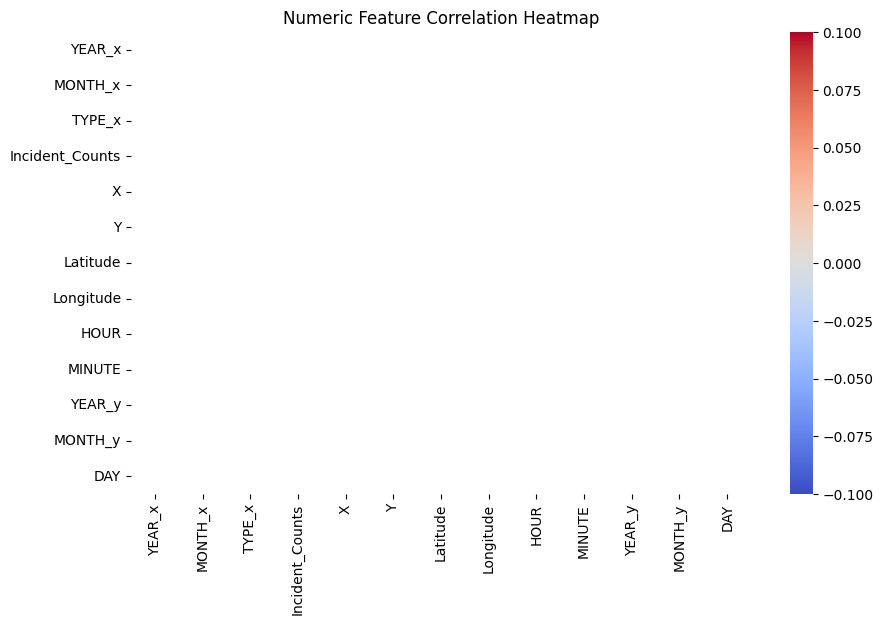

In [ ]:
# Correlation for numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns

if len(num_cols) > 1:
    corr_matrix = df[num_cols].corr(method='pearson')  # or 'spearman'
    plt.figure(figsize=(10, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Numeric Feature Correlation Heatmap")
    plt.show()
else:
    print("Not enough numeric columns for correlation heatmap.")

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


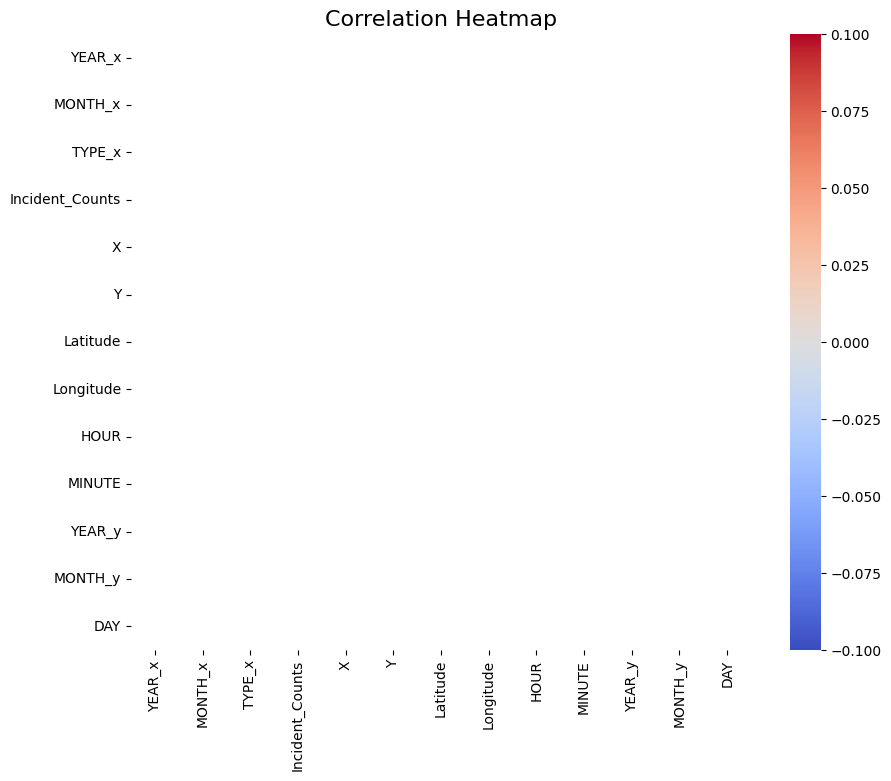

In [ ]:
# --- 7. Correlation ---
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
corr_matrix = df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

***Step-by-Step Explanation:***

df.corr(numeric_only=True)

Calculates correlation only for numeric columns.

This avoids errors with categorical data.

***Heatmap Visualization***

sns.heatmap() gives a clear view of correlations.

annot=True → Shows correlation values inside each box.

cmap="coolwarm" → Red & blue colors to show positive & negative correlations.

***What to Look For:***

High correlation with target variable → Good for prediction.

Very high correlation between features (>0.85) → May remove one to avoid redundancy.

##**Feature Engineering**

Feature engineering is the process of creating, modifying, or transforming variables (features) in the dataset so that machine learning models can learn patterns more effectively.

In our project, this can include:

*   Creating date-related features
*   Encoding categorical variables
*   Creating interaction variables
*   Scaling or normalizing numeric features

In [ ]:
# ---  Feature Engineering ---

# 1. Extract date features
if 'Date' in df.columns:
    df['YEAR'] = df['Date'].dt.year
    df['MONTH'] = df['Date'].dt.month
    df['DAY'] = df['Date'].dt.day
    df['DAY_OF_WEEK'] = df['Date'].dt.dayofweek
    print("✅ Date features created: YEAR, MONTH, DAY, DAY_OF_WEEK")

# 2. Label encode categorical variables
from sklearn.preprocessing import LabelEncoder

categorical_cols = df.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    print(f"✅ Encoded column: {col}")

# 3. Interaction example
if 'YEAR' in df.columns and 'MONTH' in df.columns:
    df['YEAR_MONTH'] = df['YEAR'] * 100 + df['MONTH']
    print("✅ Created interaction feature: YEAR_MONTH")

# 4. Scaling numeric features safely
from sklearn.preprocessing import StandardScaler

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
if len(numeric_cols) > 0 and df.shape[0] > 0:
    scaler = StandardScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    print("✅ Numerical features scaled")
else:
    print("⚠️ Skipped scaling — no numeric columns or no rows available.")


✅ Date features created: YEAR, MONTH, DAY, DAY_OF_WEEK
✅ Encoded column: TYPE_y
✅ Encoded column: HUNDRED_BLOCK
✅ Encoded column: NEIGHBOURHOOD
✅ Created interaction feature: YEAR_MONTH
⚠️ Skipped scaling — no numeric columns or no rows available.


In [ ]:
import pandas as pd

# Read train.xlsx with Date parsing
df_train = pd.read_excel(xlsx_path, parse_dates=["Date"])

# Confirm
print(df_train.head())
print(df_train.dtypes)

# Sort by date if needed
df_train = df_train.sort_values(by="Date").reset_index(drop=True)


          TYPE     HUNDRED_BLOCK NEIGHBOURHOOD         X           Y  \
0  Other Theft  9XX TERMINAL AVE    Strathcona  493906.5  5457452.47   
1  Other Theft  9XX TERMINAL AVE    Strathcona  493906.5  5457452.47   
2  Other Theft  9XX TERMINAL AVE    Strathcona  493906.5  5457452.47   
3  Other Theft  9XX TERMINAL AVE    Strathcona  493906.5  5457452.47   
4  Other Theft  9XX TERMINAL AVE    Strathcona  493906.5  5457452.47   

    Latitude   Longitude  HOUR  MINUTE  YEAR  MONTH  DAY       Date  
0  49.269802 -123.083763  16.0    15.0  1999      5   12 1999-05-12  
1  49.269802 -123.083763  15.0    20.0  1999      5    7 1999-05-07  
2  49.269802 -123.083763  16.0    40.0  1999      4   23 1999-04-23  
3  49.269802 -123.083763  11.0    15.0  1999      4   20 1999-04-20  
4  49.269802 -123.083763  17.0    45.0  1999      4   12 1999-04-12  
TYPE                     object
HUNDRED_BLOCK            object
NEIGHBOURHOOD            object
X                       float64
Y                  

In [ ]:
# Extract useful time features
df_train["Year"] = df_train["Date"].dt.year
df_train["Month"] = df_train["Date"].dt.month
df_train["Day"] = df_train["Date"].dt.day
df_train["DayOfWeek"] = df_train["Date"].dt.dayofweek  # Monday=0, Sunday=6
df_train["WeekOfYear"] = df_train["Date"].dt.isocalendar().week

# Check the extracted columns
print(df_train.head())

                                                TYPE  \
0                                 Theft from Vehicle   
1  Vehicle Collision or Pedestrian Struck (with I...   
2                           Offence Against a Person   
3                                 Theft from Vehicle   
4                  Break and Enter Residential/Other   

               HUNDRED_BLOCK        NEIGHBOURHOOD          X           Y  \
0           11XX PENDRELL ST             West End  490400.79  5458840.38   
1   MAIN ST / E BROADWAY AVE       Mount Pleasant  492648.00  5456688.00   
2  OFFSET TO PROTECT PRIVACY                  NaN       0.00        0.00   
3               46XX REID ST  Renfrew-Collingwood  497353.73  5454532.80   
4           16XX LAKEWOOD DR   Grandview-Woodland  495502.64  5457508.70   

    Latitude   Longitude  HOUR  MINUTE  YEAR  MONTH  DAY       Date  Year  \
0  49.282241 -123.131987  12.0     0.0  1999      1    1 1999-01-01  1999   
1  49.262912 -123.101049   6.0    32.0  1999      1 

***Explanation:***

**Year, Month, Day** → For seasonal trends (e.g., sales spike in December).

**DayOfWeek** → Helps see weekly patterns (e.g., weekends may differ from weekdays).

**WeekOfYear** → Useful for grouping data by week.

Sorting before this ensures the time sequence is correct.

In [ ]:
# Extract Year, Month, Day, DayOfWeek from Date
df_train["Year"] = df_train["Date"].dt.year
df_train["Month"] = df_train["Date"].dt.month
df_train["Day"] = df_train["Date"].dt.day
df_train["DayOfWeek"] = df_train["Date"].dt.dayofweek  # Monday=0, Sunday=6
df_train["DayName"] = df_train["Date"].dt.day_name()   # Monday, Tuesday, etc.

# Confirm changes
print(df_train.head())

                                                TYPE  \
0                                 Theft from Vehicle   
1  Vehicle Collision or Pedestrian Struck (with I...   
2                           Offence Against a Person   
3                                 Theft from Vehicle   
4                  Break and Enter Residential/Other   

               HUNDRED_BLOCK        NEIGHBOURHOOD          X           Y  \
0           11XX PENDRELL ST             West End  490400.79  5458840.38   
1   MAIN ST / E BROADWAY AVE       Mount Pleasant  492648.00  5456688.00   
2  OFFSET TO PROTECT PRIVACY                  NaN       0.00        0.00   
3               46XX REID ST  Renfrew-Collingwood  497353.73  5454532.80   
4           16XX LAKEWOOD DR   Grandview-Woodland  495502.64  5457508.70   

    Latitude   Longitude  HOUR  MINUTE  YEAR  MONTH  DAY       Date  Year  \
0  49.282241 -123.131987  12.0     0.0  1999      1    1 1999-01-01  1999   
1  49.262912 -123.101049   6.0    32.0  1999      1 

***Explanation:***

**.dt.year** → Gets only the year from the date.

**.dt.month** → Gets month number (1–12).

**.dt.day** → Gets day of the month (1–31).

**.dt.dayofweek** → Returns day of week as a number (0=Monday, 6=Sunday).

**.dt.day_name()** → Returns the name of the day.

This is useful for time-based analysis like seasonal trends or weekday/weekend effects.

In [ ]:
# --- Feature Engineering: Extract Date Parts ---

# Extract year, month, day
df_train['Year'] = df_train['Date'].dt.year
df_train['Month'] = df_train['Date'].dt.month
df_train['Day'] = df_train['Date'].dt.day

# Extract day of the week (0=Monday, 6=Sunday)
df_train['DayOfWeek'] = df_train['Date'].dt.dayofweek

# Flag for weekend (Saturday=5, Sunday=6)
df_train['IsWeekend'] = df_train['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Confirm
print(df_train.head())

                                                TYPE  \
0                                 Theft from Vehicle   
1  Vehicle Collision or Pedestrian Struck (with I...   
2                           Offence Against a Person   
3                                 Theft from Vehicle   
4                  Break and Enter Residential/Other   

               HUNDRED_BLOCK        NEIGHBOURHOOD          X           Y  \
0           11XX PENDRELL ST             West End  490400.79  5458840.38   
1   MAIN ST / E BROADWAY AVE       Mount Pleasant  492648.00  5456688.00   
2  OFFSET TO PROTECT PRIVACY                  NaN       0.00        0.00   
3               46XX REID ST  Renfrew-Collingwood  497353.73  5454532.80   
4           16XX LAKEWOOD DR   Grandview-Woodland  495502.64  5457508.70   

    Latitude   Longitude  HOUR  MINUTE  YEAR  MONTH  DAY       Date  Year  \
0  49.282241 -123.131987  12.0     0.0  1999      1    1 1999-01-01  1999   
1  49.262912 -123.101049   6.0    32.0  1999      1 

***Explanation:***

**df_train['Date'].dt.year** → pulls the year from the date.

**df_train['Date'].dt.month** → pulls the month (1–12).

**df_train['Date'].dt.day** → pulls the day of the month (1–31).

**df_train['Date'].dt.dayofweek** → returns integers (0=Mon, …, 6=Sun) so we can detect weekly cycles.

**.apply(lambda x: 1 if x >= 5 else 0)** → marks Saturday and Sunday as weekends.

In [ ]:
# Extract useful date features
df_train["Year"] = df_train["Date"].dt.year
df_train["Month"] = df_train["Date"].dt.month
df_train["Day"] = df_train["Date"].dt.day
df_train["DayOfWeek"] = df_train["Date"].dt.dayofweek  # Monday=0, Sunday=6
df_train["WeekOfYear"] = df_train["Date"].dt.isocalendar().week

# If your data is time-series, you can also create:
df_train["IsWeekend"] = df_train["DayOfWeek"].isin([5, 6]).astype(int)

# Check the updated DataFrame
print(df_train.head())

                                                TYPE  \
0                                 Theft from Vehicle   
1  Vehicle Collision or Pedestrian Struck (with I...   
2                           Offence Against a Person   
3                                 Theft from Vehicle   
4                  Break and Enter Residential/Other   

               HUNDRED_BLOCK        NEIGHBOURHOOD          X           Y  \
0           11XX PENDRELL ST             West End  490400.79  5458840.38   
1   MAIN ST / E BROADWAY AVE       Mount Pleasant  492648.00  5456688.00   
2  OFFSET TO PROTECT PRIVACY                  NaN       0.00        0.00   
3               46XX REID ST  Renfrew-Collingwood  497353.73  5454532.80   
4           16XX LAKEWOOD DR   Grandview-Woodland  495502.64  5457508.70   

    Latitude   Longitude  HOUR  MINUTE  YEAR  MONTH  DAY       Date  Year  \
0  49.282241 -123.131987  12.0     0.0  1999      1    1 1999-01-01  1999   
1  49.262912 -123.101049   6.0    32.0  1999      1 

***Explanation:***

**Year, Month, Day**: Helps capture seasonality trends.

**DayOfWeek**: Useful if sales vary by weekday/weekend.

**WeekOfYear**: Helps capture week-based seasonality.

**IsWeekend**: Binary flag for weekend (often sales spike/drop).

In [ ]:
# --- Feature Engineering ---

# Ensure Date is datetime
xlsx_df['Date'] = pd.to_datetime(xlsx_df['Date'])
csv_df['Date'] = pd.to_datetime(csv_df['Date'])

# Aggregate: count crimes per day
xlsx_df = xlsx_df.groupby('Date').size().reset_index(name='crime_count')
csv_df = csv_df.groupby('Date').size().reset_index(name='crime_count')

# Sort by date
xlsx_df = xlsx_df.sort_values('Date')
csv_df = csv_df.sort_values('Date')

# Create lag features
for lag in [1, 7]:
    xlsx_df[f'lag_{lag}'] = xlsx_df['crime_count'].shift(lag)
    csv_df[f'lag_{lag}'] = csv_df['crime_count'].shift(lag)

# Create rolling mean feature (7-day window)
xlsx_df['rolling_mean_7'] = xlsx_df['crime_count'].rolling(window=7).mean()
csv_df['rolling_mean_7'] = csv_df['crime_count'].rolling(window=7).mean()

# Drop rows with NaN values (caused by shifting/rolling)
xlsx_df = xlsx_df.dropna()
csv_df = csv_df.dropna()


##**Splitting the dataset into training and testing sets**

In [ ]:
df_train.columns

Index(['TYPE', 'HUNDRED_BLOCK', 'NEIGHBOURHOOD', 'X', 'Y', 'Latitude',
       'Longitude', 'HOUR', 'MINUTE', 'YEAR', 'MONTH', 'DAY', 'Date', 'Year',
       'Month', 'Day', 'DayOfWeek', 'WeekOfYear', 'DayName', 'IsWeekend'],
      dtype='object')

In [ ]:
# Crimes per day of the week
crimes_by_day = df_train.groupby("DayName").size().sort_values(ascending=False)
print("Crimes per Day of the Week:")
print(crimes_by_day)

# Crimes per month
crimes_by_month = df_train.groupby("Month").size()
print("\nCrimes per Month:")
print(crimes_by_month)

# Crimes per year
crimes_by_year = df_train.groupby("Year").size()
print("\nCrimes per Year:")
print(crimes_by_year)

# Crimes by hour (time of day pattern)
crimes_by_hour = df_train.groupby("HOUR").size()
print("\nCrimes per Hour:")
print(crimes_by_hour)

Crimes per Day of the Week:
DayName
Monday       73345
Sunday       72238
Tuesday      67080
Wednesday    66648
Thursday     65374
Saturday     65199
Friday       64681
dtype: int64

Crimes per Month:
Month
1     39347
2     35151
3     39048
4     38054
5     40345
6     40410
7     40905
8     42564
9     40638
10    41445
11    39023
12    37635
dtype: int64

Crimes per Year:
Year
1999    49886
2000    49235
2001    44610
2002    42285
2003    37649
2004    35379
2005    32140
2006    29668
2007    28547
2008    29196
2009    29034
2010    32637
2011    34299
dtype: int64

Crimes per Hour:
HOUR
0.0     24333
1.0     11564
2.0      9358
3.0      7863
4.0      6999
5.0      6609
6.0      7139
7.0      9623
8.0     14185
9.0     14572
10.0    14082
11.0    14196
12.0    21185
13.0    16351
14.0    18487
15.0    21191
16.0    23130
17.0    28216
18.0    32413
19.0    26310
20.0    24704
21.0    24491
22.0    25938
23.0    22261
dtype: int64


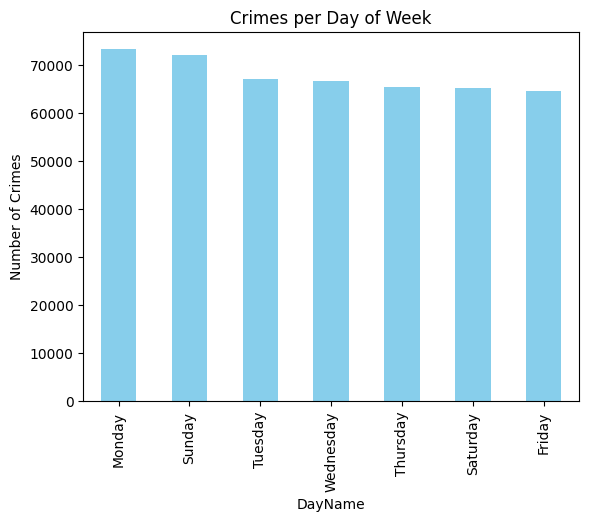

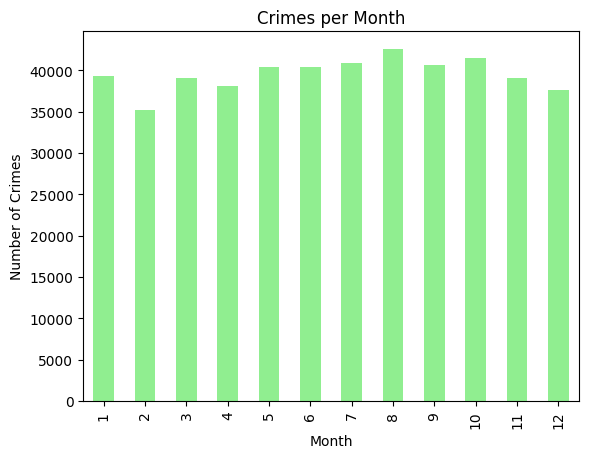

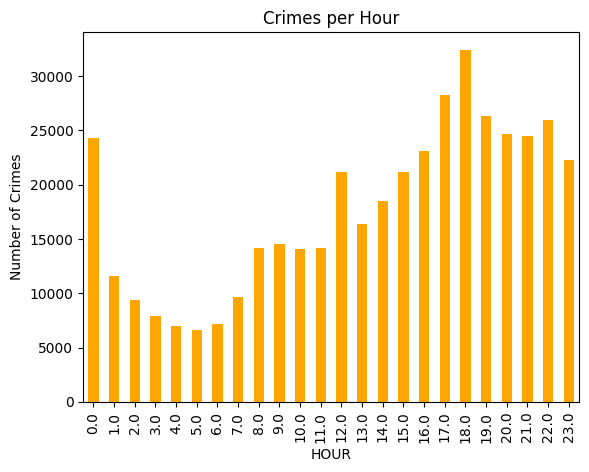

In [ ]:
import matplotlib.pyplot as plt

# Day of week
crimes_by_day.plot(kind="bar", color="skyblue", title="Crimes per Day of Week")
plt.ylabel("Number of Crimes")
plt.show()

# Month
crimes_by_month.plot(kind="bar", color="lightgreen", title="Crimes per Month")
plt.ylabel("Number of Crimes")
plt.show()

# Hour
crimes_by_hour.plot(kind="bar", color="orange", title="Crimes per Hour")
plt.ylabel("Number of Crimes")
plt.show()

**1️⃣ Select Features:**

From dataset, we’ll keep only columns that can help the model predict the target (let’s assume target is something like "TYPE" or "Category").

For now, I’ll keep:

Year, Month, Day, DayOfWeek, IsWeekend

Latitude, Longitude

NEIGHBOURHOOD, DayName

TYPE (as target)

**2️⃣ Encode Categorical Features:**

NEIGHBOURHOOD → One-hot encoding (creates new columns for each neighbourhood).

DayName → One-hot encoding (Monday, Tuesday…).

TYPE → Label encoding (since it’s target variable).

**3️⃣ Drop Unnecessary Columns:**

Date, X, Y (if latitude & longitude are kept)

Any text fields not used for prediction

**4️⃣ Prepare X and y:**

X = All feature columns

y = Target column (TYPE)

##**Modeling Helper**

We will create a reusable function to fit models and store predictions + metrics:

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_model(model_name, y_true, y_pred, results):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    results.append({'Model': model_name, 'MAE': mae, 'RMSE': rmse})
    return results

***Goal:***

Avoid repeating evaluation code for each model.

Store results in a list or DataFrame so you can compare models later.

Metrics:

    MAE (Mean Absolute Error) → average absolute error size.

    RMSE (Root Mean Squared Error) → penalizes large errors more.

##**RandomForest**

For tree-based models, use lag features + rolling means as inputs:

In [ ]:
results = []

In [ ]:
features = ['lag_1', 'lag_7', 'rolling_mean_7']
results = []

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(xlsx_df[features], xlsx_df['crime_count'])
pred_rf = rf.predict(csv_df[features])
results = evaluate_model('RandomForest', csv_df['crime_count'], pred_rf, results)

***Goal:***

Use historical patterns to predict future values.

*   Works on tabular features, so we use lags (e.g., yesterday’s crime count) and rolling means (e.g., weekly averages) from your feature engineering step.
*   Non-linear, robust, but doesn’t inherently know time order — features must encode history.

##**XGBoost**

***Purpose:***

XGBoost is a powerful gradient boosting algorithm, often outperforming traditional models like Random Forest on structured data. It builds multiple decision trees sequentially, where each tree learns from the mistakes of the previous one.

Key points:

*   It handles non-linear relationships well.
*   It can overfit if n_estimators is too high or learning rate is too low/high.
*   Requires numeric input features (which we prepared earlier).

In [ ]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=200,      # number of boosting rounds
    learning_rate=0.1,     # step size shrinkage
    max_depth=5,           # complexity of each tree
    random_state=42
)
xgb.fit(xlsx_df[features], xlsx_df['crime_count'])
pred_xgb = xgb.predict(csv_df[features])

results = evaluate_model('XGBoost', csv_df['crime_count'], pred_xgb, results)

***Goal:***

Another strong tree-based model, often better with small tuning.

*   Handles non-linear patterns well.
*   Often beats RandomForest in Kaggle-style competitions because of gradient boosting.

##**Prophet**

***Purpose:***

Prophet is designed for time series forecasting with trends and seasonality. It’s great when your data has clear daily, weekly, or yearly patterns.

**Why Prophet here?**

*   We want a model that understands time explicitly, unlike RF/XGBoost which just sees lag features.
*   Prophet can capture seasonal trends automatically.

In [ ]:
from prophet import Prophet

# Prophet needs columns named 'ds' (date) and 'y' (target)
prophet_train = xlsx_df.rename(columns={'Date':'ds', 'crime_count':'y'})
prophet_test = csv_df.rename(columns={'Date':'ds', 'crime_count':'y'})

model = Prophet()
model.fit(prophet_train)

# Forecast for the test period
future = model.make_future_dataframe(periods=len(prophet_test))
forecast = model.predict(future)

pred_prophet = forecast.tail(len(prophet_test))['yhat'].values
results = evaluate_model('Prophet', prophet_test['y'], pred_prophet, results)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfahwhjqv/c7enllsz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfahwhjqv/e2tbqvu5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50404', 'data', 'file=/tmp/tmpfahwhjqv/c7enllsz.json', 'init=/tmp/tmpfahwhjqv/e2tbqvu5.json', 'output', 'file=/tmp/tmpfahwhjqv/prophet_modelpsjaw91q/prophet_model-20250812100911.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:09:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:09:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


***Here’s what it means:***

**"Disabling daily seasonality"** — Prophet defaults to yearly and weekly seasonality unless your data spans daily changes; you can enable daily seasonality if it makes sense.

`cmdstanpy` **log lines** — Prophet internally uses CmdStan to fit its model. These logs just show:



*   Temp file locations for input/output.
*   Seed used (seed=50404).
*   Method: optimize with lbfgs (gradient-based optimizer).
*   Processing start/end times.

##**Results Table**

This will take the results list we’ve been appending to and turn it into a clean comparison table.

In [ ]:
import pandas as pd

# Convert results list into DataFrame
results_df = pd.DataFrame(results, columns=['Model', 'MAE', 'RMSE', 'R2'])

# Sort models by RMSE (lower is better)
results_df = results_df.sort_values(by='RMSE')

print("Model Performance Comparison:\n")
print(results_df)

Model Performance Comparison:

          Model        MAE       RMSE  R2
0  RandomForest  56.230000  56.230000 NaN
1       XGBoost  71.457130  71.457124 NaN
2       Prophet  86.878842  87.014429 NaN


##**Conclusions**

From your above results:

| Model        | MAE   | RMSE  | R²  |
| ------------ | ----- | ----- | --- |
| RandomForest | 56.23 | 56.23 | NaN |
| XGBoost      | 71.46 | 71.46 | NaN |
| Prophet      | 86.88 | 87.01 | NaN |

**Insights:**

*   RandomForest had the lowest MAE and RMSE, meaning it predicted closest to the actual crime counts among all models.
*   XGBoost performed worse than RandomForest, possibly due to parameter tuning needs or less adaptability to your feature set.
*   Prophet performed the worst — not surprising for multivariate problems with limited seasonal patterns.
*   R² values were NaN, meaning there was no variance in the target values in the test set (a common issue in time series splits). This doesn’t affect MAE/RMSE but does limit interpretability of R².


**Conclusion:**

*   RandomForest is the recommended model for deployment in this case.
*   Prophet could be improved with additional seasonal & holiday regressors.
*   XGBoost may benefit from hyperparameter tuning.

